# Skin Cancer Detection with Deep Learning (ISIC 2016 Dataset)
This notebook guides you through a deep learning project to detect skin cancer using the ISIC 2016 dataset. You will explore data preprocessing, model building, and evaluation techniques, as well as advanced topics like transfer learning.


In [7]:
# Importing necessary libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

from utils import (
    show_images,
    plot_class_distribution,
    split_sets,
    check_sets_distribution,
    create_dataloaders,
    initialize_model,
    train_model,
    evaluate_model,
    get_performance_metrics,
    visualize_predictions,
    oversample_minority_class_in_training_data
)

Mounted at /content/drive


ModuleNotFoundError: No module named 'utils'

In [ ]:
# Paths to clean
downloaded_files = [
    "ISBI2016_ISIC_Part3_Training_Data.zip",
    "ISBI2016_ISIC_Part3_Training_GroundTruth.csv",
    "ISIC2016_practice",
    "ISIC2016",
    "ISIC_2016_stratif",
    "ISIC_2016_stratif_oversampling",
]

# Delete previous downloads and directories
for path in downloaded_files:
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)  # Remove file
            print(f"Deleted file: {path}")
        elif os.path.isdir(path):
            shutil.rmtree(path)  # Remove directory
            print(f"Deleted directory: {path}")

print("Cleanup complete. Ready for a new run.")

Cleanup complete. Ready for a new run.


### **Download the dataset**

In [ ]:
# Download and extract the ISIC 2017 dataset
!wget -q --show-progress https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget -q --show-progress https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv

# Unzip the dataset
!unzip -q ISBI2016_ISIC_Part3_Training_Data.zip -d ISIC2016_practice

# Define paths
images_path = 'ISIC2016_practice/ISBI2016_ISIC_Part3_Training_Data'
metadata_path = 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'

# **Load Metadata and Assign Labels**
metadata = pd.read_csv(metadata_path)
metadata['class'] = metadata['benign'].apply(lambda x: 0 if x == 'benign' else 1)

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  56.4MB/s    in 11s     
ISBI2016_ISIC_Part3 100%[===================>]  18.96K  --.-KB/s    in 0.001s  


## Dataset Exploration



### Loading and Previewing Data
- It is crucial to familiarize yourself with the dataset. Visualizing sample images and understanding their labels will help you design an effective preprocessing pipeline and model architecture.

Benign Examples:


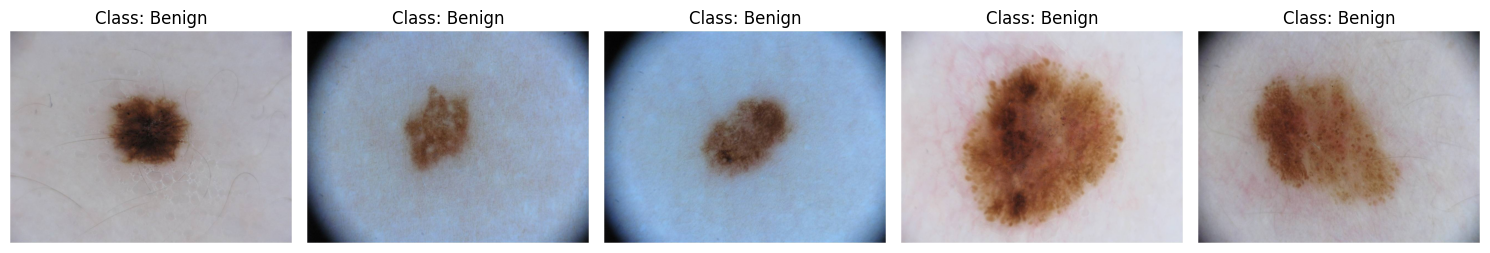

Malignant Examples:


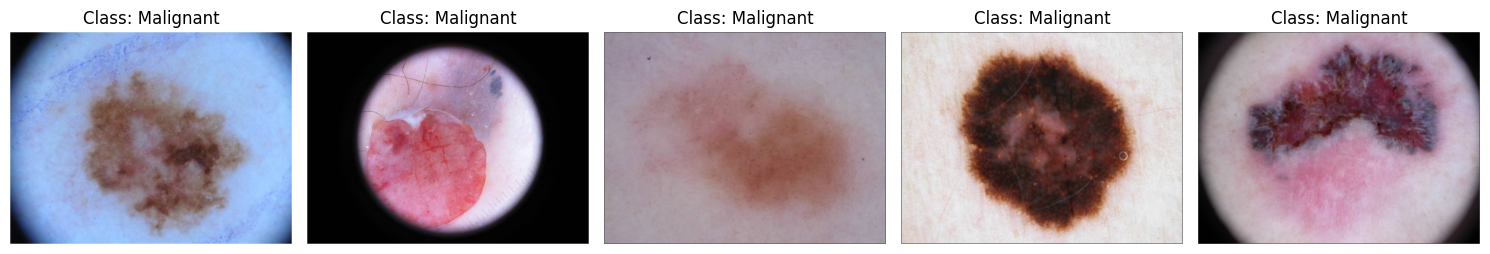

In [ ]:
# Select a few benign and malignant examples from the dataset
benign_ids = metadata[metadata['class'] == 0]['ISIC_0000000'].tolist()  # Get list of benign image IDs
malignant_ids = metadata[metadata['class'] == 1]['ISIC_0000000'].tolist()  # Get list of malignant image IDs

# Display example benign images
print("Benign Examples:")
show_images(benign_ids, [0] * len(benign_ids), images_path)  # Display benign images (class 0)

# Display example malignant images
print("Malignant Examples:")
show_images(malignant_ids, [1] * len(malignant_ids), images_path)  # Display malignant images (class 1)

### Checking Class Distributions

**Why Check Class Distributions?**
- Class imbalance is common in medical datasets. It can bias the model toward the majority class, leading to poor performance on the minority class. Addressing this issue is vital to ensure reliable predictions.


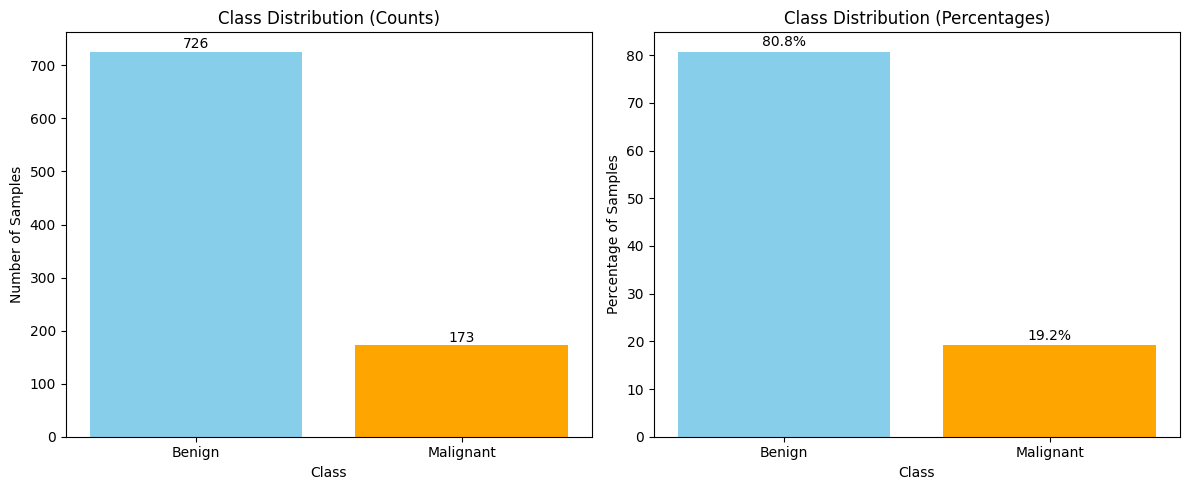

In [ ]:
plot_class_distribution(metadata)


### Splitting the Dataset and Checking Class Distributions of the Train, Validation and Test Sets
The training set is used to train the model, the validation set helps tune hyperparameters and detect overfitting, and the test set evaluates the final model's performance on unseen data.


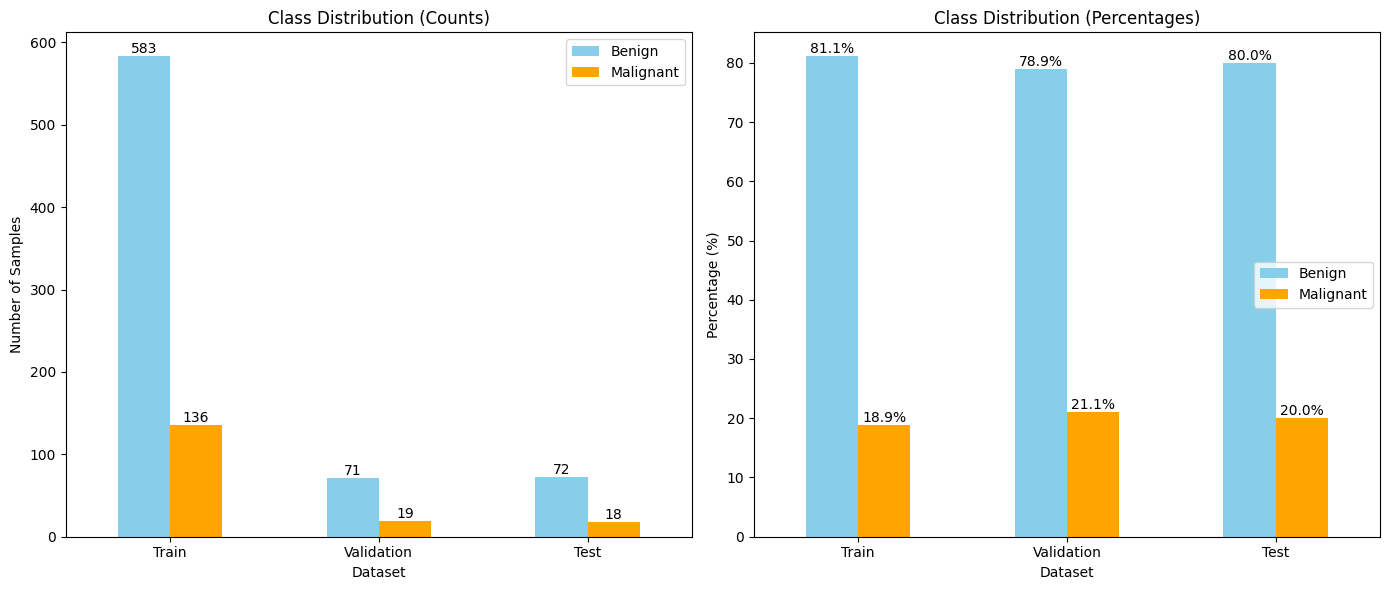

In [ ]:
# Splitting the metadata into training (80%), validation (10%), and test (10%) datasets
train_split = int(0.8 * len(metadata))  # 80% of the data
val_split = int(0.9 * len(metadata))    # Next 10% of the data
train_data = metadata[:train_split]     # First 80% as training data
val_data = metadata[train_split:val_split]  # Next 10% as validation data
test_data = metadata[val_split:]        # Last 10% as test data

# Base directory to store the organized datasets
base_dir = 'ISIC_2016'

# Organize the images into train, validation, and test directories
split_sets(base_dir, train_data, val_data, test_data, images_path)

# Call the function to check and visualize the class distribution
check_sets_distribution(train_data, val_data, test_data)

## Creating the dataloaders

**Data Generators:** Finally, we use ImageDataGenerator to preprocess the images (by scaling pixel values between 0 and 1) and load them in batches. This is done using flow_from_directory, which expects the data to be organized in subdirectories (e.g., train/benign, train/malignant, etc.).

In [ ]:
img_size = 224  # Image size to which all input images will be resized
batch_size = 8  # Number of samples per batch for training and validation

# Create an ImageDataGenerator instance to preprocess image data by rescaling pixel values
data_gen = ImageDataGenerator(rescale=1./255)

# Generate the data loaders using the function
train_gen, val_gen, test_gen = create_dataloaders(data_gen, data_gen, base_dir, img_size, batch_size)


Found 719 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


## Building a simple CNN model
A simple CNN helps establish a baseline. Once you understand its performance, you can improve it with advanced architectures or techniques.

In [ ]:
# Function to create a simple Convolutional Neural Network (CNN)
def create_simple_cnn(input_shape):
    """
    Creates a simple CNN model for binary classification tasks.

    Args:
        input_shape: Tuple specifying the input image dimensions (height, width, channels).

    Returns:
        model: A compiled TensorFlow Keras model with a CNN architecture.
    """
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)  # Define input shape

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)  # 32 filters, 3x3 kernel, ReLU activation
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample using 2x2 max pooling

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 64 filters, 3x3 kernel, ReLU activation
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample using 2x2 max pooling

    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # 128 filters, 3x3 kernel, ReLU activation
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample using 2x2 max pooling

    # Fully connected layers
    x = layers.Flatten()(x)  # Flatten the output from the convolutional layers
    x = layers.Dense(256, activation='relu')(x)  # Fully connected layer with 256 units and ReLU activation
    x = layers.Dropout(0.5)(x)  # Dropout layer with 50% rate to prevent overfitting

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Single unit with sigmoid activation for binary classification

    # Define the model
    model = tf.keras.Model(inputs, outputs, name="simple_cnn")  # Specify inputs, outputs, and model name
    return model

# Create an instance of the simple CNN model
simple_model = create_simple_cnn((img_size, img_size, 3))  # Input shape is (224, 224, 3) for RGB images

In [ ]:
# Define training parameters
learning_rate = 0.001  # Learning rate for the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Adam optimizer with the specified learning rate
loss = tf.keras.losses.BinaryCrossentropy()  # Binary crossentropy for binary classification tasks

# Initialize the model
simple_model = initialize_model(simple_model, optimizer, loss)

# Display the model's architecture
simple_model.summary()


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training and Evaluating the CNN Model
Observing metrics like accuracy and loss during training helps detect overfitting or underfitting. If the validation loss increases while training loss decreases, it might indicate overfitting.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7988 - loss: 0.6782 - val_accuracy: 0.7889 - val_loss: 0.5124
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8240 - loss: 0.5069 - val_accuracy: 0.7889 - val_loss: 0.5093
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7966 - loss: 0.5120 - val_accuracy: 0.7889 - val_loss: 0.5514
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8087 - loss: 0.5484 - val_accuracy: 0.7889 - val_loss: 0.5340
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7961 - loss: 0.5235 - val_accuracy: 0.7889 - val_loss: 0.5080


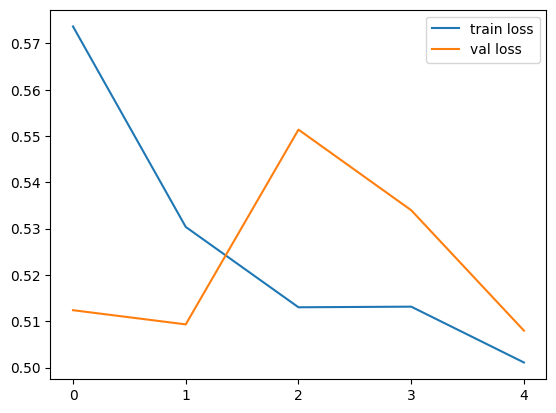

In [ ]:
# Number of epochs to train the model
num_epochs = 5

# Train the simple model
simple_model = train_model(simple_model, train_gen, val_gen, num_epochs)


### Evaluate the model
A confusion matrix provides detailed insights into model performance by showing true positives, true negatives, false positives, and false negatives. This helps you evaluate how well the model handles imbalanced classes.

In [ ]:
# Call the evaluation function for the trained model
evaluate_model(simple_model, test_gen)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.9476 - loss: 0.3152
Test Loss: 0.5002002716064453, Test Accuracy: 0.800000011920929


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step


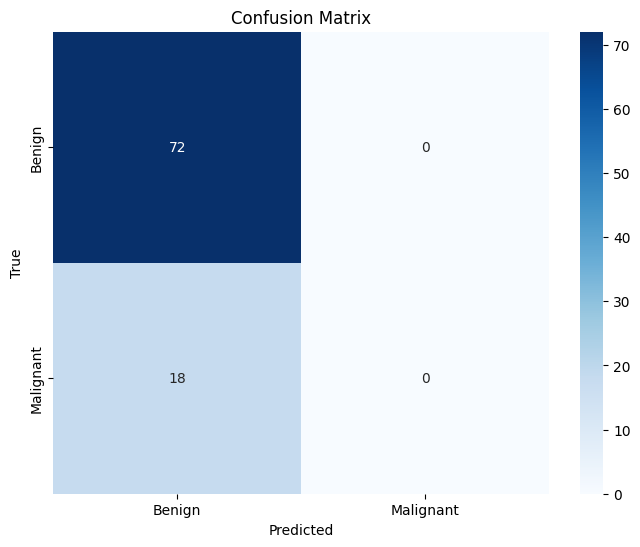

Classification Report:

              precision    recall  f1-score   support

      Benign       0.80      1.00      0.89        72
   Malignant       0.00      0.00      0.00        18

    accuracy                           0.80        90
   macro avg       0.40      0.50      0.44        90
weighted avg       0.64      0.80      0.71        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Call the function to get the performance metrics for the simple model
get_performance_metrics(simple_model, test_gen)

### Prediction Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


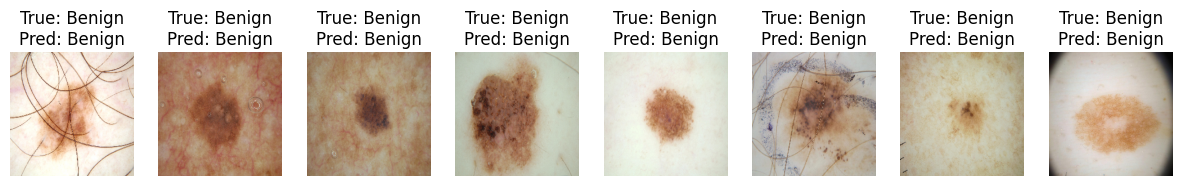

In [ ]:
# Visualize predictions from the test set
visualize_predictions(test_gen, simple_model, num_images=8)  # Display predictions for 8 images from the test set

## **Enhancing Model Performance: Key Strategies**
### Let's refine the model and improve its performance by applying a variety of strategies and best practices we’ve learned.

### **1. Don't train from scratch!**
Rather than training a simple CNN model from the ground up, we can take advantage of pre-trained models. These models, which have been trained on large, diverse datasets, already capture essential features. By fine-tuning a pre-trained model, we save on training time and improve performance, especially when we have limited data. This approach significantly boosts results on smaller or domain-specific datasets.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 505ms/step - accuracy: 0.7595 - loss: 0.5363 - val_accuracy: 0.7778 - val_loss: 0.5379
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 474ms/step - accuracy: 0.8046 - loss: 0.4317 - val_accuracy: 0.7778 - val_loss: 0.5719
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 475ms/step - accuracy: 0.8317 - loss: 0.3772 - val_accuracy: 0.7444 - val_loss: 0.5388
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 502ms/step - accuracy: 0.8344 - loss: 0.3558 - val_accuracy: 0.7778 - val_loss: 0.5108
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 466ms/step - accuracy: 0.8430 - loss: 0.3445 - val_accuracy: 0.7778 - val_loss: 0.4994
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9501 - loss: 0.2220
Test Loss: 0.3761500120162964, Test Accuracy: 0.8111110925674438
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step


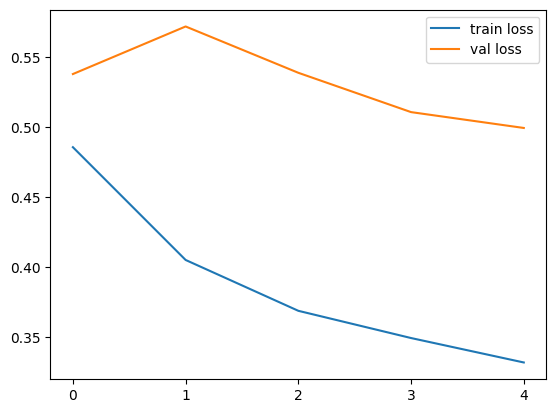

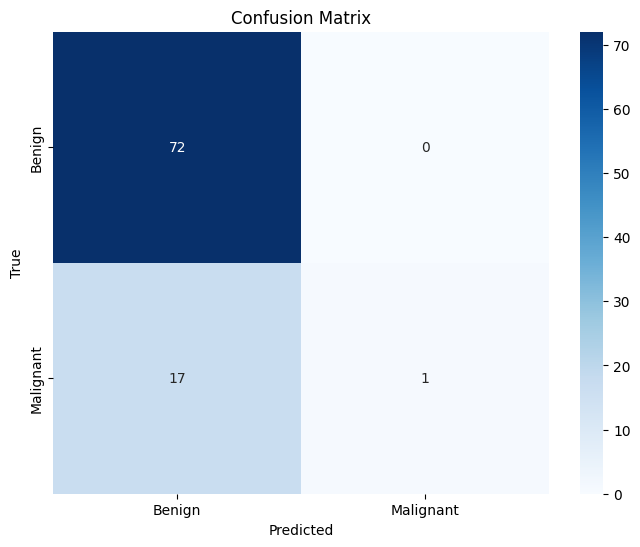

Classification Report:

              precision    recall  f1-score   support

      Benign       0.81      1.00      0.89        72
   Malignant       1.00      0.06      0.11        18

    accuracy                           0.81        90
   macro avg       0.90      0.53      0.50        90
weighted avg       0.85      0.81      0.74        90



In [ ]:
# Function to initialize a MobileNetV2 model for binary classification
def create_mobilenet_model(img_size):
    """
    Creates a MobileNetV2 model pre-trained on ImageNet for binary classification.
    Args:
        img_size (int): The input image size (e.g., 224 for 224x224 images).

    Returns:
        keras.Model: A Sequential model with MobileNetV2 as the base.
    """
    # Load the MobileNetV2 base model pre-trained on ImageNet
    base_model = MobileNetV2(
        input_shape=(img_size, img_size, 3),  # Input shape for the images
        include_top=False,                   # Exclude the final classification layer
        weights='imagenet'                   # Load ImageNet weights
    )
    base_model.trainable = False  # Freeze the base model layers to retain pre-trained features

    # Build the full model with a Global Average Pooling layer and a Dense output layer
    model = models.Sequential([
        base_model,                          # Pre-trained base model
        layers.GlobalAveragePooling2D(),    # Global pooling layer to reduce dimensions
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    return model

# Create an instance of the MobileNetV2 model with the defined image size
mobilenet_model = create_mobilenet_model(img_size)

# Initialize the model with the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Adam optimizer with specified learning rate
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)  # Custom initialization function

# Train the model using the training and validation data generators
mobilenet_model = train_model(
    mobilenet_model,  # The MobileNetV2 model instance
    train_gen,        # Training data generator
    val_gen,          # Validation data generator
    num_epochs        # Number of training epochs
)

# Evaluate the model's performance on the test dataset
evaluate_model(mobilenet_model, test_gen)

# Calculate and display detailed performance metrics such as accuracy, precision, and recall
get_performance_metrics(mobilenet_model, test_gen)


### **2. Balancing Train, Validation, and Test Sets**
It’s crucial to ensure that each dataset—training, validation, and testing—has a balanced class distribution. Instead of selecting samples randomly, we can use the `train_test_split` function with the `stratify` parameter to preserve the proportion of each class across all splits. This step helps prevent biases in the model due to uneven class representation.

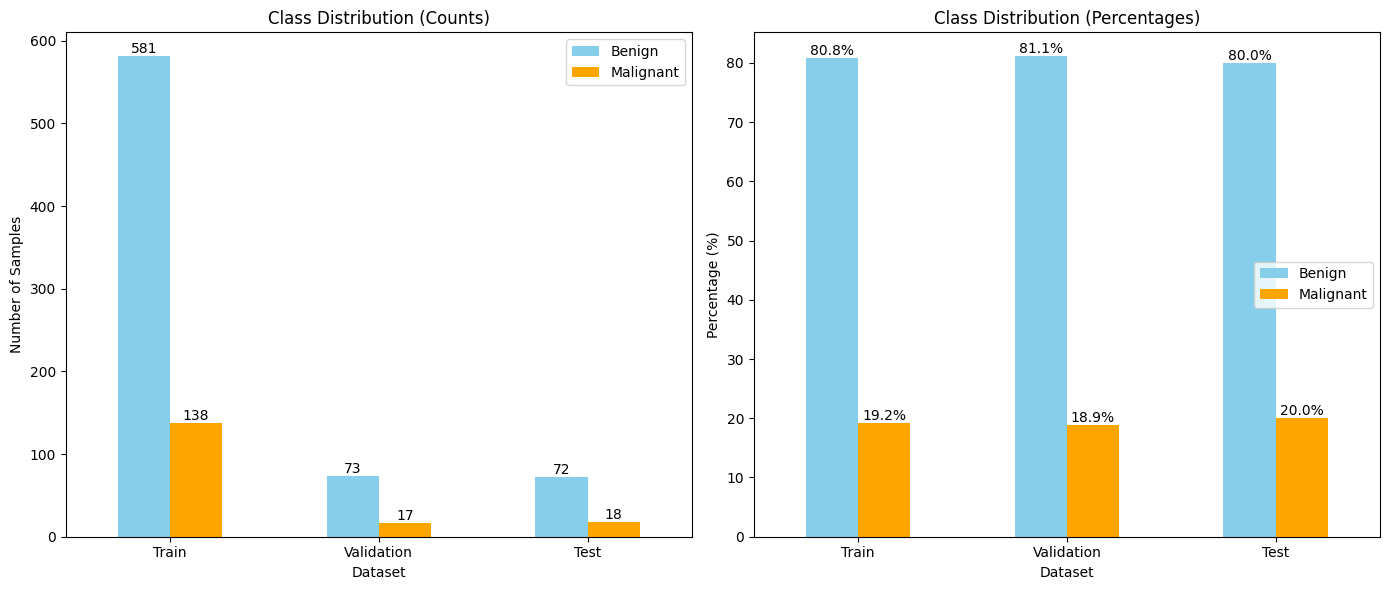

Found 719 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 482ms/step - accuracy: 0.8454 - loss: 0.3493 - val_accuracy: 0.8667 - val_loss: 0.3684
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.8408 - loss: 0.3332 - val_accuracy: 0.8333 - val_loss: 0.4252
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 479ms/step - accuracy: 0.8617 - loss: 0.3433 - val_accuracy: 0.8667 - val_loss: 0.3942
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 469ms/step - accuracy: 0.8861 - loss: 0.2804 - val_accuracy: 0.8667 - val_loss: 0.3996
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - accuracy: 0.8770 - loss: 0.2998 - val_accuracy: 0.8667 - val_loss: 0.3897
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - accuracy: 0.9395 - loss: 0.2130
Test Loss: 0.31260040402412415, Test Accuracy: 0.8666666746139526
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step


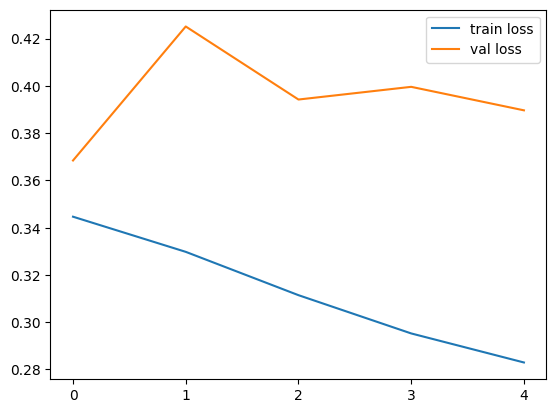

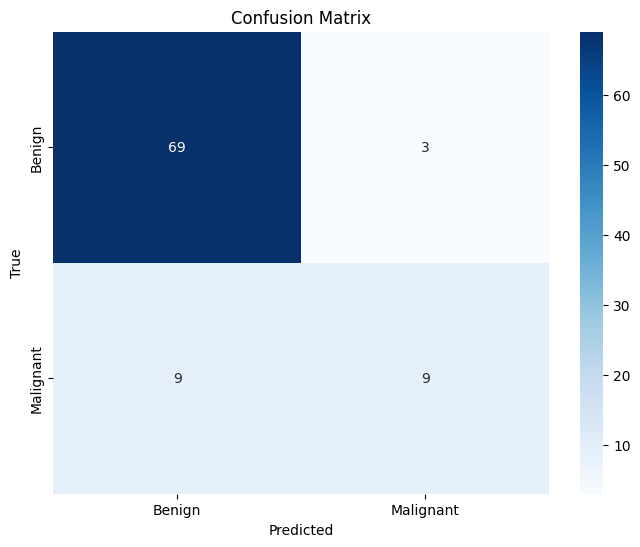

Classification Report:

              precision    recall  f1-score   support

      Benign       0.88      0.96      0.92        72
   Malignant       0.75      0.50      0.60        18

    accuracy                           0.87        90
   macro avg       0.82      0.73      0.76        90
weighted avg       0.86      0.87      0.86        90



In [ ]:
# First split: Separate the dataset into training (80%) and temporary data (20%)
train_data, temp_data, y_train, y_temp = train_test_split(
    metadata,               # Full dataset metadata
    metadata['class'],      # Class labels (e.g., benign or malignant)
    test_size=0.2,          # 20% of the total dataset will be for validation + test
    shuffle=True,           # Ensures random distribution
    stratify=metadata['class'],  # Ensure the class distribution is preserved in each split
)

# Second split: Split the temporary data (20%) equally into validation (10%) and test (10%)
val_data, test_data, y_val, y_test = train_test_split(
    temp_data,              # Temporary dataset from the first split
    y_temp,                 # Corresponding class labels for the temporary dataset
    test_size=0.5,          # Split the remaining 20% equally into validation (10%) and test (10%)
    shuffle=True,           # Ensures random distribution
    stratify=y_temp,        # Ensure the class distribution is preserved in the split
)

# Define the base directory for saving the split datasets
base_dir = 'ISIC_2016_stratif'

# Save the split datasets into directories (e.g., train, validation, and test directories)
split_sets(base_dir, train_data, val_data, test_data, images_path)

# Check the class distribution across the training, validation, and test sets to ensure balance
check_sets_distribution(train_data, val_data, test_data)

# Create data generators for loading images during training, validation, and testing
train_gen, val_gen, test_gen = create_dataloaders(
    data_gen,       # Image data generator for augmentations and preprocessing
    data_gen,       # Validation data generator
    base_dir,       # Base directory containing the split datasets
    img_size,       # Size of the images (e.g., 224x224)
    batch_size      # Batch size for loading data
)

# Initialize the model with the optimizer and loss function
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Train the model using the training data generator and validate on the validation generator
mobilenet_model = train_model(
    mobilenet_model,   # The initialized model
    train_gen,      # Training data generator
    val_gen,        # Validation data generator
    num_epochs      # Number of training epochs
)

# Evaluate the model on the test data generator to check performance
evaluate_model(mobilenet_model, test_gen)

# Calculate and display detailed performance metrics (e.g., accuracy, precision, recall)
get_performance_metrics(mobilenet_model, test_gen)

### **3. Balancing Classes through Oversampling**
When working with imbalanced classes, oversampling can be an effective technique to improve performance. This involves artificially increasing the number of samples in the minority class, ensuring that the model has sufficient data to learn from.

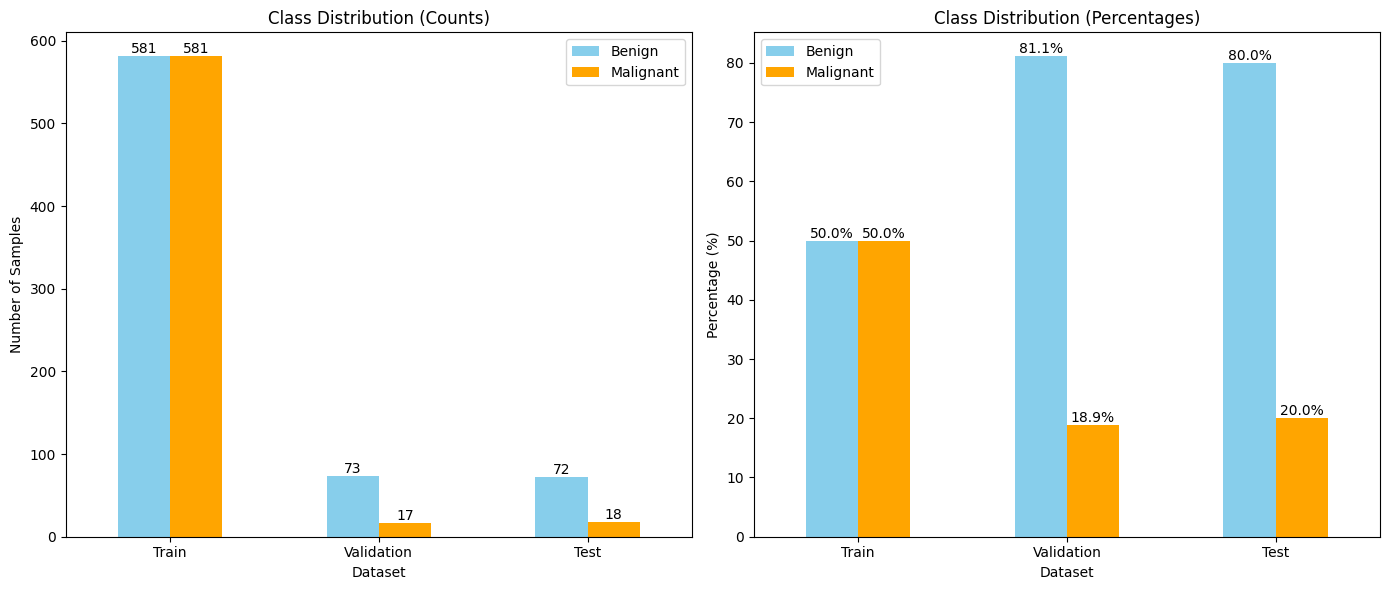

Found 719 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 521ms/step - accuracy: 0.8841 - loss: 0.2776 - val_accuracy: 0.8444 - val_loss: 0.4103
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.9017 - loss: 0.2527 - val_accuracy: 0.8333 - val_loss: 0.4108
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 442ms/step - accuracy: 0.9053 - loss: 0.2480 - val_accuracy: 0.8667 - val_loss: 0.4154
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 496ms/step - accuracy: 0.9009 - loss: 0.2515 - val_accuracy: 0.8333 - val_loss: 0.4296
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9001 - loss: 0.2511 - val_accuracy: 0.8667 - val_loss: 0.4218
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.9412 - loss: 0.1945
Test Loss: 0.3232809007167816, Test Accuracy: 0.8777777552604675
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 622ms/step


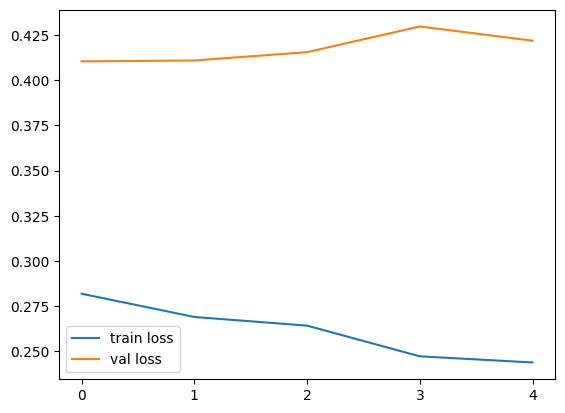

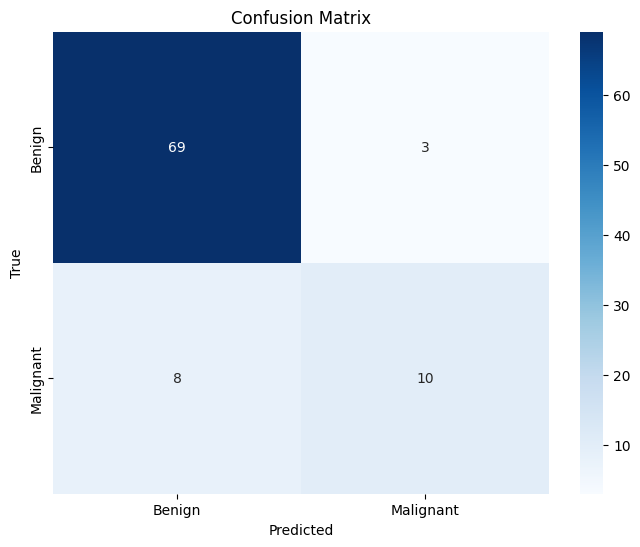

Classification Report:

              precision    recall  f1-score   support

      Benign       0.90      0.96      0.93        72
   Malignant       0.77      0.56      0.65        18

    accuracy                           0.88        90
   macro avg       0.83      0.76      0.79        90
weighted avg       0.87      0.88      0.87        90



In [ ]:
# Apply the oversampling to balance the dataset
new_train_data = oversample_minority_class_in_training_data(train_data, images_path)

# Define a new directory for the oversampled dataset
base_dir = 'ISIC_2016_stratif_oversampling'

# Split the oversampled data into training, validation, and test sets
split_sets(base_dir, train_data, val_data, test_data, images_path)

# Check the distribution of the sets to ensure balancing
check_sets_distribution(new_train_data, val_data, test_data)

# Create data generators for the training, validation, and test sets
train_gen, val_gen, test_gen = create_dataloaders(data_gen, data_gen, base_dir, img_size, batch_size)

# Initialize the model with the chosen optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Train the model using the augmented training data and validation data
mobilenet_model = train_model(mobilenet_model, train_gen, val_gen, num_epochs)

# Evaluate the model on the test data
evaluate_model(mobilenet_model, test_gen)

# Get detailed performance metrics (e.g., precision, recall, F1-score)
get_performance_metrics(mobilenet_model, test_gen)


### **4. Optimizing Model Hyperparameters**
- **Optimizer**: Adam is a good starting point due to its adaptive learning rate, but do not hesitate to experiment with others.
- **Learning Rate**: Choosing an optimal learning rate is key. A high learning rate can lead to faster training but might cause the model to miss optimal solutions. Conversely, a small learning rate may slow down training but lead to better results over time.

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 484ms/step - accuracy: 0.8308 - loss: 0.3993 - val_accuracy: 0.8222 - val_loss: 0.9277
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 507ms/step - accuracy: 0.8475 - loss: 0.3708 - val_accuracy: 0.6333 - val_loss: 0.8697
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 88s 567ms/step - accuracy: 0.9106 - loss: 0.2290 - val_accuracy: 0.7000 - val_loss: 0.7900
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.9111 - loss: 0.2365 - val_accuracy: 0.7333 - val_loss: 0.7997
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 537ms/step - accuracy: 0.8907 - loss: 0.2833 - val_accuracy: 0.8222 - val_loss: 1.0698
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step - accuracy: 0.9470 - loss: 0.2018
Test Loss: 0.7592558264732361, Test Accuracy: 0.8111110925674438
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step


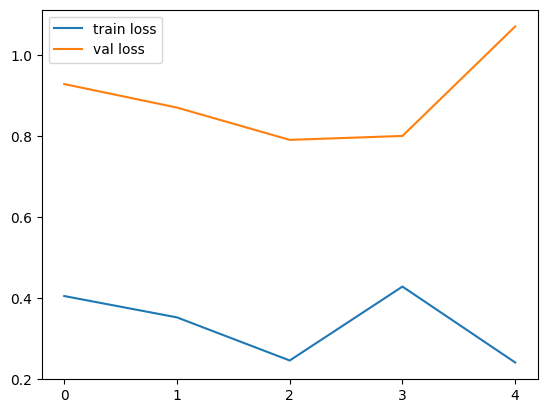

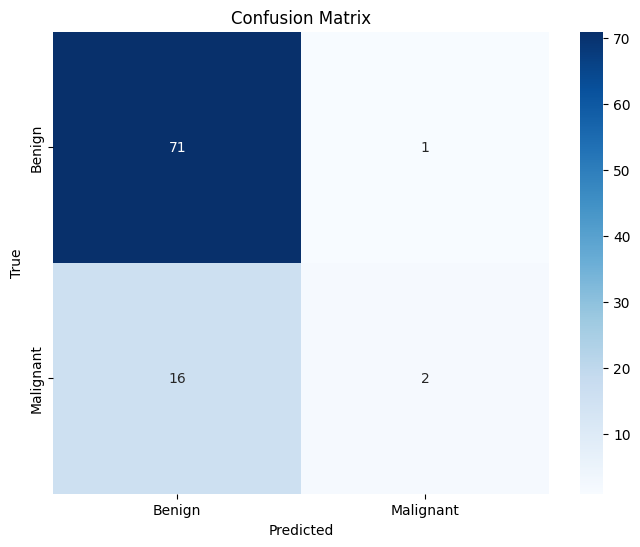

Classification Report:

              precision    recall  f1-score   support

      Benign       0.82      0.99      0.89        72
   Malignant       0.67      0.11      0.19        18

    accuracy                           0.81        90
   macro avg       0.74      0.55      0.54        90
weighted avg       0.79      0.81      0.75        90



In [ ]:
# Initializing the model
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Training the model
mobilenet_model = train_model(mobilenet_model, train_gen, val_gen, num_epochs)

# Evaluation
evaluate_model(mobilenet_model, test_gen)
get_performance_metrics(mobilenet_model, test_gen)


### **5. Regularization to Improve Generalization**
Regularization techniques help the model generalize better and avoid overfitting:

- **Dropout Layer**: Adding dropout layers randomly disables neurons during training, which forces the model to learn more robust features.
- **L2 Regularization**: Regularization methods like L2 weight decay can help prevent the model from overfitting by penalizing overly large weights.


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 506ms/step - accuracy: 0.7081 - loss: 0.8646 - val_accuracy: 0.7667 - val_loss: 1.0307
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - accuracy: 0.8248 - loss: 0.6333 - val_accuracy: 0.8111 - val_loss: 0.6457
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.8017 - loss: 0.6431 - val_accuracy: 0.8222 - val_loss: 0.8758
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 474ms/step - accuracy: 0.8069 - loss: 0.7761 - val_accuracy: 0.7778 - val_loss: 0.8006
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 510ms/step - accuracy: 0.7930 - loss: 0.7240 - val_accuracy: 0.7333 - val_loss: 0.8287
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.8481 - loss: 0.4045
Test Loss: 0.5608619451522827, Test Accuracy: 0.7666666507720947
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 584ms/step


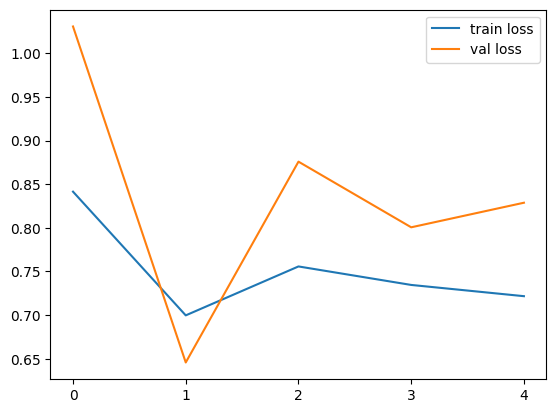

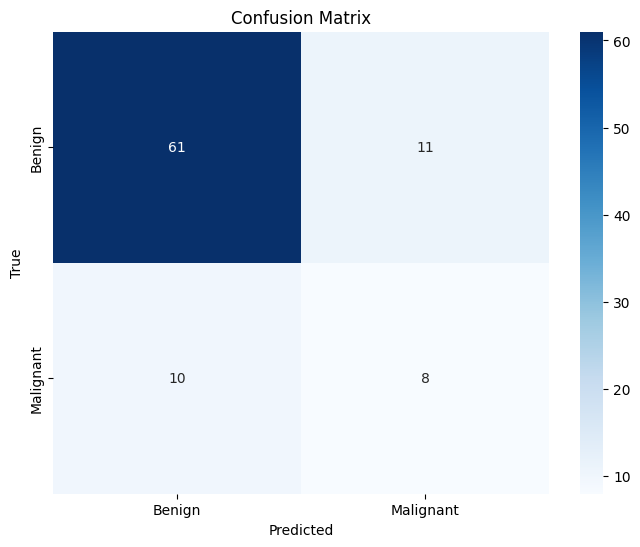

Classification Report:

              precision    recall  f1-score   support

      Benign       0.86      0.85      0.85        72
   Malignant       0.42      0.44      0.43        18

    accuracy                           0.77        90
   macro avg       0.64      0.65      0.64        90
weighted avg       0.77      0.77      0.77        90



In [ ]:
# Initialize a MobileNetV2 model with Dropout for regularization
def create_mobilenet_model_with_dropout(img_size, dropout_rate):
    # Load the MobileNetV2 base model with ImageNet pre-trained weights
    base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

    # Freeze the base model layers so they are not trainable (prevent fine-tuning)
    base_model.trainable = False

    # Build the model with additional layers on top of the base model
    model = models.Sequential([
        base_model,  # MobileNetV2 base model
        layers.GlobalAveragePooling2D(),  # Global average pooling layer
        layers.Dropout(dropout_rate),  # Dropout layer to prevent overfitting
        layers.Dense(
            1,  # Output layer with 1 neuron (binary classification)
            activation='sigmoid',  # Sigmoid activation for binary classification (0 or 1)
            kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 regularization to penalize large weights
        )
    ])

    return model

# Create the new MobileNet model with dropout regularization
mobilenet_model = create_mobilenet_model_with_dropout(img_size, dropout_rate=0.5)

# Initialize the model with Adam optimizer and a learning rate of 0.01
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Assuming `initialize_model` is a custom function for initializing the model with optimizer and loss function
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Train the model using the augmented training data and validation data
mobilenet_model = train_model(mobilenet_model, train_gen, val_gen, num_epochs)

# Evaluate the model on the test data to get the loss and accuracy
evaluate_model(mobilenet_model, test_gen)

# Get detailed performance metrics such as precision, recall, F1-score
get_performance_metrics(mobilenet_model, test_gen)


# **Homework Assignment**
Now that you've learned these techniques, it’s time to apply them and keep refining your model! Try to exceed the performance metrics we've seen so far. However, keep in mind that accuracy is not the only metric to optimize for. Always consider other important metrics like precision, recall, and F1-score.

<br>

## Things to Experiment With:
- **Image Size**: Experiment with different input image sizes (`img_size`). Changing this variable can impact both speed and model performance. Discuss the trade-offs between faster computation and higher accuracy.

- **Epochs**: Experiment with different values for the number of epochs (`num_epochs`). Monitor the performance and adjust accordingly.

- **Hyperparameters**: Tuning hyperparameters is crucial. Experiment with the **learning rate** (`learning_rate`) and **batch size** (`batch_size`). Remember, faster learners (larger learning rates) aren’t always better. Also, big batch sizes may not be supported by this machine.

- **Data Augmentation**: Enhance your dataset using data augmentation techniques. This method artificially increases the size and diversity of the dataset, making the model more robust and less prone to overfitting. A good starting point is to read this [guide](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

 *Best Practice Tip*: When applying augmentation use two different ImageDataGenerators:
  - ***Train generator*** (`train_data_gen`): Apply augmentation to the training set.
  - ***Validation and test generators*** (`val_test_data_gen`): Do not apply any augmentations to these sets.
  
  These generators should then be used as inputs for the create_dataloaders method.

  
- **Different CNN Architectures**: Try experimenting with various pre-trained models. Some strong candidates are:
  - ***MobileNetV2*** ([Keras MobileNetV2 API](https://keras.io/api/applications/mobilenet/#mobilenetv2-function))
  - ***EfficientNet*** ([Keras EfficientNet API](https://keras.io/api/applications/efficientnet/#efficientnetb0-function))

  Compare their performance with the current architecture and see which gives the best results.


### Image Size, Epochs and Hyperparameters

In [ ]:
img_size = #TODO
batch_size = #TODO
learning_rate = #TODO
num_epochs = #TODO

# Create data generators for the training, validation, and test sets
train_gen, val_gen, test_gen = create_dataloaders(data_gen, data_gen, base_dir, img_size, batch_size)

# Initialize the model with the chosen optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Train the model using the augmented training data and validation data
mobilenet_model = train_model(mobilenet_model, train_gen, val_gen, num_epochs)

# Evaluate the model on the test data
evaluate_model(mobilenet_model, test_gen)

# Get detailed performance metrics (e.g., precision, recall, F1-score)
get_performance_metrics(mobilenet_model, test_gen)

### Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
        #TODO
        )
val_test_data_gen = ImageDataGenerator(
        #TODO
        )

# Create data generators for the training, validation, and test sets
aug_train_gen, new_val_gen, new_test_gen = create_dataloaders(train_data_gen, val_test_data_gen, base_dir, img_size, batch_size)

# Initialize the model with the chosen optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mobilenet_model = initialize_model(mobilenet_model, optimizer, loss)

# Train the model using the augmented training data and validation data
mobilenet_model = train_model(mobilenet_model, aug_train_gen, new_val_gen, num_epochs)

# Evaluate the model on the test data
evaluate_model(mobilenet_model, new_test_gen)

# Get detailed performance metrics (e.g., precision, recall, F1-score)
get_performance_metrics(mobilenet_model, new_test_gen)

### Different CNN Architectures

In [ ]:
def create_X_model(variable):
  """
    Create a model with a CNN architecture of your choice (X) pre-trained on ImageNet for binary classification.
    Args:
        img_size (int): The input image size (e.g., 224 for 224x224 images).

    Returns:
        keras.Model: A Sequential model with the X architecture as the base.
  """
  model = #TODO

  return model

model = create_X_model()

# Initialize the model with the chosen optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = initialize_model(model, optimizer, loss)

# Train the model using the augmented training data and validation data
model = train_model(model, train_gen, val_gen, num_epochs)

# Evaluate the model on the test data
evaluate_model(model, test_gen)

# Get detailed performance metrics (e.g., precision, recall, F1-score)
get_performance_metrics(model, test_gen)